# 뉴스기사 제목에 따른 댓글 분석 프로젝트

## WHY

- 네이버 댓글을 보면, 항상 사람들이 화나있다.
- 그런데 화나있는 사람들을 보면, 제목만 보고 쭉 내려서 댓글로 분노를 표출하는 사람들이 보인다.
- 제목을 달기 전에, 미리 사람들이 화날지 아닐지 알 수 있다면 어떨까?

## DATA
- 네이버 뉴스기사 제목 데이터 (일 단위)
- 해당 제목의 댓글 데이터



## HOW
- 데이터 수집 방법 : BS4를 이용한 정적 크롤링
- 한국어 형태소 분석 : Mecab
- 댓글 감정에 대한 라벨링 방법 : 네이버 CLOVA Sentiment API 활용, 긍정 / 부정반응 기록
- Bidirectional LSTM을 이용해 감성분류

## RESULT
- 작성된 댓글의 80% 가량이 부정적 반응이었다.
- 부정적인 댓글의 길이가 상대적으로 길어지지는 않았다.
- 제목에 따라서 얼마나 부정적인 반응이 나올지 예측할 수 있었다.
- 다만 의아한 경우도 있었는데, 예를들어 '불법 유흥주점서 술자리 배우 최진혁 검찰 송치' 제목의 경우 92.14% 확률로 긍정적 반응을 예측했다.

## OPINION
 - 데이터의 양이 더 많았다면 정확하게 할 수 있지 않았을까?
 - CLOVA API 활용시 돈이 들어서 기사 당 10개의 댓글만을 라벨링했고,  
  그에 따라 라벨링의 정밀도가 떨어지는게 아쉬웠다.
 - 모델을 활용해 사람들의 긍정적인 반응만을 유도하도록 기사가 쓰여진다면 과연 어떨까 했었다.  
 그러나 예쁜것만 본다고 한들 행복할 리 없다는 생각이 들었고, 지금처럼 사람들이 쉽게 부정적인 감정을 온라인에 털어내는 만큼 현실에서는 긍정적으로 반응하며 행복했으면 좋겠다는 결론을 내렸다.
 - 앞으로도 네이버 뉴스댓글이 한국인의 감정 쓰레기통으로서 잘 작동하기를 바란다.

## CODE

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 1.56 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 43.4 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-11 21:38:01--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
import requests
import json
from tqdm import tqdm
from urllib.parse import urlparse, parse_qs

In [ ]:
from bs4 import BeautifulSoup # html 을 파싱하기 위한 모듈
import random
import urllib.request

네이버 뉴스기사 댓글 크롤링

In [ ]:
date = "20220111" # 날짜는 임의로 정했다. 날짜 값도 반복문으로 처리할 경우, 해당 기간동안 발생한 댓글 전부를 가져올수 있을듯!
article_page_num = 1
category_url = 'https://news.naver.com/main/list.nhn?mode=LS2D&mid=shm&sid2=269&sid1=100&date={}&page={}'
header = {
    'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36',
}

total_article_list = []
prev_article_list = []
while(True):
    req_url = category_url.format(date, article_page_num)
    html = requests.get(req_url, headers = header)
    soup = BeautifulSoup(html.content, 'html.parser')
    temp_article_list = list(set([url_info.find('a').get('href') for url_info in soup.find_all('dt')]))
    
    #page 마지막에 도달할 경우 가져온 값이 이전값과 동일, 해당 경우를 체크하기 위해
    if(temp_article_list == prev_article_list):
        break
    else:
        prev_article_list = list(temp_article_list)
        total_article_list.extend(temp_article_list)
        article_page_num+=1

print("크롤링한 기사 수 : ",len(total_article_list)) # 가져오는 기사의 수가 몇개인지

크롤링한 기사 수 :  3164


각 URL마다 크롤링으로 뽑아내야 할 것 : 제목, 감정등급

기사가 너무 많아... 1000개만 추려냅시다 는 일단 100개

In [ ]:
import random
newslink = random.sample(total_article_list,100)

In [ ]:
# 기사 링크를 입력하면 타이틀을 뱉어주는 함수
def titler(url):
#url = "https://news.naver.com/main/read.naver?mode=LSD&mid=shm&sid1=100&oid=087&aid=0000877196"
  header = {
      'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36',
      'accept' : "*/*",
      'accept-encoding' : 'gzip, deflate, br',
      'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
      }

  html = requests.get(url, headers = header)
  soup = BeautifulSoup(html.content, 'html.parser')
  title = soup.find('title')
  return title.text

In [ ]:
title_list = []
for news in tqdm(newslink):
  title_list.append(titler(news))

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


In [ ]:
newslink

['https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=003&aid=0010937883',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=057&aid=0001634756',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=421&aid=0005837388',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=001&aid=0012910062',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=018&aid=0005124571',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=079&aid=0003595837',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=417&aid=0000774242',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=056&aid=0011192737',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=119&aid=0002565953',
 'https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=3

In [ ]:
title_list

['김동연 새로운물결 대선 후보 스타트업 간담회 : 네이버 뉴스',
 '"윤 후보, 이 말 듣고 웃었다"…화해 비하인드 밝힌 이준석 : 네이버 뉴스',
 '축사 하는 송영길 대표 : 네이버 뉴스',
 '신년 기자회견 마치고 취재진 질문 받는 윤석열 대선후보 : 네이버 뉴스',
 '윤석열 "北 선제타격" 언급…전작권 전환엔 "능력 갖춰지면" : 네이버 뉴스',
 '[노컷브이]\'#멸치 #콩\' 올려놓고…尹 "해시태그 달아본 적 없어" : 네이버 뉴스',
 '이재명 "열린민주당 통합 투표, 압도적 찬성… 진정한 민주주의 실현할 것" : 네이버 뉴스',
 '‘16세 정당가입’·‘경찰관 형사책임 감면법’ 등 법안 46건 처리 : 네이버 뉴스',
 '윤석열, 레벨D방호복입고 간담회 : 네이버 뉴스',
 '與의원·국무총리 특보도 ‘스벅 불매’ 동참…여권 발 불매운동 불 붙나 : 네이버 뉴스',
 '금융노조 지부 대표자 간담회 갖는 김동연 : 네이버 뉴스',
 '올 하반기부터 공공기관에 ‘노동이사’…정당가입 연령도 만 18→16세로 : 네이버 뉴스',
 '속초해경 관할 연안 해역 사망사고, 전년보다 30％ 감소 : 네이버 뉴스',
 "대장동 첫 재판, '대장동 5인방' 모두 출석 : 네이버 뉴스",
 '유시민 "젠더 이슈에 이재명 영악, 윤석열은 투기적 행태" : 네이버 뉴스',
 '경찰관 직무집행법 법률 개정안 본회의 통과 : 네이버 뉴스',
 '[전문]이재명 신경제 비전 선포식 발표문 : 네이버 뉴스',
 '이준석 “尹, 내부 조사에서 2030 중심으로 지지율 반등” : 네이버 뉴스',
 '윤석열, 안철수와 단일화 묻자 “국민들이 판단할 문제” : 네이버 뉴스',
 '회동하는 여야 원내수석부대표 : 네이버 뉴스',
 '[속보]이재명 "과학기술·산업·교육대전환, 지금 반드시 실천해야" : 네이버 뉴스',
 '종편도 후보자 토론회 가능…공직선거법 개정안 국회 본회의 통과 : 네이버 뉴스',
 '북한, 동해상으로 미상 발사체 또 발사…"연이은 무력 시위 이례적" : 네이버 

URL으로 제목 긁어오는건 성공.

In [ ]:
"""
url = "https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=003&aid=0010939256"
header = {
    'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36',
    'accept' : "*/*",
    'accept-encoding' : 'gzip, deflate, br',
    'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
    }

comment_list = []
html = requests.get(url, headers = header)
soup = BeautifulSoup(html.content, 'html.parser')
reaction = soup.find(id = 'spiLayer')
reaction1 = reaction.find(class_='_reactionModule u_likeit')
reaction2
"""

URL으로 감정표현 긁어오는건 실패. 크롬에서 뜯어보면 값이 멀쩡한데, HTML 문서를 뜯어와보면 0으로 뜸.  
헤더문제인가 싶어 이리저리 값을 바꿔봤으나 동일함.    
결과적으로 해당 데이터를 라벨 데이터로 쓰려했으나 크롤링 실패로 불가능.

라벨링 할 방법 없나 비지도학습 이리저리 찾아보다가 네이버 CLOVA Sentiment  API 발견.  
해당 API(한국어 감정분석) 활용해서 댓글을 라벨링하고, 제목을 학습시키면  
기사 제목에 따른 사람들의 부정적 / 긍정적 반응을 예측할 수 있을 것이다.

클로바 API 활용 함수

In [ ]:
def clova(content):
  client_id = "vp6x02gplx"
  client_secret = "LDnNPxnYAIN8pDlpBlVVE54rnaornTwHGfllLM81"
  url="https://naveropenapi.apigw.ntruss.com/sentiment-analysis/v1/analyze"
  headers = {
      "X-NCP-APIGW-API-KEY-ID": client_id,
      "X-NCP-APIGW-API-KEY": client_secret,
      "Content-Type": "application/json"
  }
  #content = "사랑한다."
  data = {
    "content": content
  }
  #print(json.dumps(data, indent=4, sort_keys=True))
  response = requests.post(url, data=json.dumps(data), headers=headers)
  rescode = response.status_code
  if(rescode == 200):
      return response.text[26:30]
      #return response.text
  else:
      print("Error : " + response.text)

In [ ]:
clova('싸늘하다.. 통장 잔고가 보인다..')

'nega'

뉴스기사의 댓글 분위기 판별 함수

In [ ]:
def chatter(article_url):
  #article_url = "https://news.naver.com/main/read.naver?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=001&aid=0012909462"
  url_param = parse_qs(urlparse(article_url).query)
  oid = url_param['oid'][0] # parameter objectid newsXXX 의 XXX부분을 채우기 위함
  aid = url_param['aid'][0] # parameter objectid newsXXX,oooooooo의 부분을 채우기 위함

  page_num = 1
  url = "https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?ticket=news&pool=cbox5&lang=ko&country=KR&objectId=news{}%2C{}&categoryId=&pageSize=100&indexSize=10&groupId=&listType=OBJECT&pageType=more&page={}"
  header = {
      'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36',
      'accept' : "*/*",
      'accept-encoding' : 'gzip, deflate, br',
      'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
      'referer' : article_url # referer 부분에 article_url 을 넣어서 가져오기!
      }

  comment_list = []

  req_url = url.format(oid, aid, page_num)
  html = requests.get(req_url, headers = header)

  test_text = html.text
  test_text = test_text.replace("_callback(","")[:-2]
  comment_text = json.loads(test_text)

  comment_list = [comment_info['contents'] for comment_info in comment_text['result']['commentList']]

  if len(comment_list) < 10: #댓글 10개 미만이면
    print("10개 미만")
    return np.nan # 결측치 처리

  comment = random.sample(comment_list,10)

  temp_list = []
    
  for com in comment: # 감정분석 API 사용
    if clova(com) == 'nega':
      temp_list.append(0) # 부정 - nagative
    else:
      temp_list.append(1) # 긍정 - positive

  sum_list = sum(temp_list)
  result = sum_list / 10

  if result < 0.5:
    print("부정적 반응",result)
  else:
    print("긍정적 반응",result)
  
  return result

부정적 반응이 절대다수 ( 95% 이상 ) 이라서 계수로 return 값을 받아야 어떻게든 될 듯

댓글이 10개 미만인 기사도 많아 데이터 줄이기 (3200 -> 1000) 없이 그대로 가기로 함.  
그랬었는데 데이터 날렸쥬? 또 2시간 쓸수는 없쥬?  
는 뒤에 변수에 다행히 남아있어서 복구 ㅠㅠ

In [ ]:
chat_list = []
for news in tqdm(newslink):
  chat_list.append(chatter(news))

  1%|          | 1/100 [00:00<00:38,  2.58it/s]

10개 미만


  2%|▏         | 2/100 [00:04<03:46,  2.31s/it]

부정적 반응 0.2


  3%|▎         | 3/100 [00:04<02:13,  1.38s/it]

10개 미만


  4%|▍         | 4/100 [00:04<01:29,  1.07it/s]

10개 미만


  5%|▌         | 5/100 [00:08<03:17,  2.08s/it]

부정적 반응 0.1


  6%|▌         | 6/100 [00:08<02:16,  1.46s/it]

10개 미만


  7%|▋         | 7/100 [00:12<03:25,  2.21s/it]

부정적 반응 0.3


  8%|▊         | 8/100 [00:12<02:25,  1.58s/it]

10개 미만


  9%|▉         | 9/100 [00:13<01:51,  1.22s/it]

10개 미만


 10%|█         | 10/100 [00:17<03:08,  2.10s/it]

부정적 반응 0.0


 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

10개 미만


 12%|█▏        | 12/100 [00:21<03:22,  2.30s/it]

부정적 반응 0.3


 13%|█▎        | 13/100 [00:22<02:25,  1.67s/it]

10개 미만


 14%|█▍        | 14/100 [00:25<03:19,  2.32s/it]

부정적 반응 0.1


 15%|█▌        | 15/100 [00:29<03:53,  2.75s/it]

부정적 반응 0.2


 16%|█▌        | 16/100 [00:29<02:47,  1.99s/it]

10개 미만


 17%|█▋        | 17/100 [00:30<02:01,  1.47s/it]

10개 미만


 18%|█▊        | 18/100 [00:33<02:56,  2.15s/it]

부정적 반응 0.2


 19%|█▉        | 19/100 [00:34<02:09,  1.60s/it]

10개 미만


 20%|██        | 20/100 [00:34<01:35,  1.20s/it]

10개 미만


 21%|██        | 21/100 [00:34<01:12,  1.10it/s]

10개 미만


 22%|██▏       | 22/100 [00:34<00:55,  1.40it/s]

10개 미만


 23%|██▎       | 23/100 [00:35<00:44,  1.73it/s]

10개 미만


 24%|██▍       | 24/100 [00:38<01:57,  1.54s/it]

부정적 반응 0.0


 25%|██▌       | 25/100 [00:39<01:26,  1.15s/it]

10개 미만


 26%|██▌       | 26/100 [00:42<02:22,  1.93s/it]

부정적 반응 0.0


 27%|██▋       | 27/100 [00:46<02:59,  2.46s/it]

부정적 반응 0.4


 28%|██▊       | 28/100 [00:47<02:12,  1.85s/it]

10개 미만


 29%|██▉       | 29/100 [00:51<02:56,  2.49s/it]

부정적 반응 0.0


 30%|███       | 30/100 [00:54<03:22,  2.89s/it]

부정적 반응 0.0


 31%|███       | 31/100 [00:55<02:25,  2.11s/it]

10개 미만


 32%|███▏      | 32/100 [00:58<02:53,  2.55s/it]

부정적 반응 0.1


 33%|███▎      | 33/100 [00:59<02:05,  1.87s/it]

10개 미만


 34%|███▍      | 34/100 [00:59<01:30,  1.38s/it]

10개 미만


 35%|███▌      | 35/100 [00:59<01:08,  1.05s/it]

10개 미만


 36%|███▌      | 36/100 [01:03<01:59,  1.87s/it]

부정적 반응 0.1


 37%|███▋      | 37/100 [01:03<01:27,  1.39s/it]

10개 미만


 38%|███▊      | 38/100 [01:03<01:04,  1.04s/it]

10개 미만


 39%|███▉      | 39/100 [01:04<00:48,  1.26it/s]

10개 미만


 40%|████      | 40/100 [01:07<01:39,  1.66s/it]

부정적 반응 0.2


 41%|████      | 41/100 [01:07<01:12,  1.23s/it]

10개 미만


 42%|████▏     | 42/100 [01:08<00:54,  1.06it/s]

10개 미만


 42%|████▏     | 42/100 [01:10<01:36,  1.67s/it]


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame([title_list,chat_list])
df = df.T
df.columns = ['text','rank']
df.to_csv('news_effect.csv')

In [ ]:
df['rank'].value_counts(0)

0.3    1
Name: rank, dtype: int64

In [ ]:
df['rank'].mean()

0.18135198135198

In [ ]:
labels = []
for row in df['rank']:
  if row > 0.18:
    labels.append(1)
  if row < 0.18:
    labels.append(0)

df['label'] = labels


ValueError: ignored

절반정도로 나뉘게 0.18 아래는 부정, 0.18 위는 긍정으로 취급

In [ ]:
train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 42)
print('훈련용 기사의 개수 :', len(train_data))
print('테스트용 기사의 개수 :', len(test_data))

훈련용 기사의 개수 : 2373
테스트용 기사의 개수 : 791


In [ ]:
df.rank

<bound method NDFrame.rank of                                                    text rank  label
912                윤석열 방역 패스 무리한 측면 많아환기 등급제 필요  네이버 뉴스  0.3      1
1798                윤석열 출생땐 천만원임차인 임대료 분의만 분담종합  네이버 뉴스  0.3      1
2837                  윤석열안철수는 거리 두는데지지층  단일화 필요  네이버 뉴스  0.2      1
1940  이재명 차별금지법 제정돼야미 금리인상에 우리나라 부동산 시장 큰 충격 받을 듯  네...  0.3      1
509                    송영길 이재명 문재인 정부에서 탄압받던 사람  네이버 뉴스  0.1      0
...                                                 ...  ...    ...
212                     윤석열 애 낳으면 년간 월 만 원 부모급여  네이버 뉴스  0.2      1
12              송영길  정부 이재명 탄압 윤영찬 아연실색 왜 내부분열을  네이버 뉴스    0      0
3062                   이준석  지지 회복세과 단일화 없어도 될 듯  네이버 뉴스  0.3      1
422                윤석열 간호사 합당한 처우해야간호법 제정에 최선종합  네이버 뉴스  0.6      1
3011              이재명  여가부 폐지 공약에 반대 넘어 대안 제시해야  네이버 뉴스  0.2      1

[1286 rows x 3 columns]>

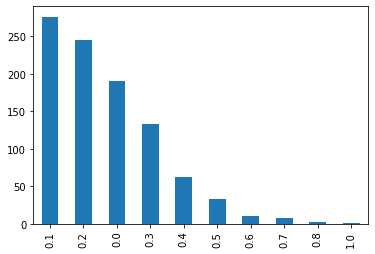

In [ ]:
train_data['rank'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('rank').size().reset_index(name = 'count'))

   rank  count
0   0.0    191
1   0.1    276
2   0.2    245
3   0.3    133
4   0.4     62
5   0.5     33
6   0.6     11
7   0.7      8
8   0.8      3
9   1.0      1


데이터 정제

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['text'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

text       0
rank    1410
dtype: int64


In [ ]:
test_data.drop_duplicates(subset = ['text'], inplace=True) # 중복 제거
test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 323


토큰화

In [ ]:
train_data

,text,rank,tokenized
1423,허소영 강원도의원 춘천시장 출마 선언 네이버 뉴스,NaN,"[허소영, 강원도, 의원, 춘천, 시장, 출마, 선언]"
1472,토론회 발언하는 정기석 위원장 네이버 뉴스,NaN,"[토론회, 발언, 정기석, 위원장]"
741,의원들과 인사나누는 김기현 원내대표 네이버 뉴스,NaN,"[의원, 인사, 나누, 김기현, 원내대표]"
2787,송영길 대표 탄 휠체어 밀며 입장하는 이재명 네이버 뉴스,NaN,"[송영길, 대표, 탄, 휠체어, 밀, 며, 입장, 이재명]"
912,윤석열 방역 패스 무리한 측면 많아환기 등급제 필요 네이버 뉴스,0.3,"[윤석열, 방역, 패스, 무리, 측면, 많, 아, 환기, 등급, 제, 필요]"
...,...,...,...
3092,이재명 경제여성 쌍끌이 공략마의 벽 돌파할까 네이버 뉴스,0.2,"[이재명, 경제, 여성, 쌍, 끌, 공략, 마의, 벽, 돌파, 할까]"
1095,질문 답변하는 안철수 후보 네이버 뉴스,NaN,"[질문, 답변, 안철수, 후보]"
1130,본회의장 앞 대장동 특검 촉구하는 국민의힘 네이버 뉴스,NaN,"[본회, 의장, 앞, 대장동, 특검, 촉구, 국민, 힘]"
1294,윤호중 추경 처리 위해 월 국회 열어야 국민의힘 협조 촉구 사진관 네이버 뉴스,NaN,"[윤호중, 추경, 처리, 위해, 월, 국회, 열, 어야, 국민, 힘, 협조, 촉구,..."


In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한',
             '에', '하', '고', '을', '를', '인', '듯', '과',
             '와', '네', '들', '듯', '지', '임', '게', '만',
             '네이버', '뉴스', '되', '음', '면']

In [ ]:
mecab = Mecab() 

train_data['tokenized'] = train_data['text'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['text'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

단어와 길이분포 확인

데이터 날아가서 다시 시작

In [ ]:
df = df[['text','rank']]
df.to_csv('news_effect.csv')

In [ ]:
df.isnull().sum()

text       0
rank    1410
dtype: int64

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.shape

(1286, 2)

In [ ]:
df

,text,rank
912,윤석열 방역 패스 무리한 측면 많아환기 등급제 필요 네이버 뉴스,0.3
1798,윤석열 출생땐 천만원임차인 임대료 분의만 분담종합 네이버 뉴스,0.3
2837,윤석열안철수는 거리 두는데지지층 단일화 필요 네이버 뉴스,0.2
1940,이재명 차별금지법 제정돼야미 금리인상에 우리나라 부동산 시장 큰 충격 받을 듯 네...,0.3
509,송영길 이재명 문재인 정부에서 탄압받던 사람 네이버 뉴스,0.1
...,...,...
212,윤석열 애 낳으면 년간 월 만 원 부모급여 네이버 뉴스,0.2
12,송영길 정부 이재명 탄압 윤영찬 아연실색 왜 내부분열을 네이버 뉴스,0
3062,이준석 지지 회복세과 단일화 없어도 될 듯 네이버 뉴스,0.3
422,윤석열 간호사 합당한 처우해야간호법 제정에 최선종합 네이버 뉴스,0.6


In [ ]:
labels = []
for row in df['rank']:
  if row > 0.18:
    labels.append(1)
  if row < 0.18:
    labels.append(0)

df['label'] = labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df

,text,rank,label
912,윤석열 방역 패스 무리한 측면 많아환기 등급제 필요 네이버 뉴스,0.3,1
1798,윤석열 출생땐 천만원임차인 임대료 분의만 분담종합 네이버 뉴스,0.3,1
2837,윤석열안철수는 거리 두는데지지층 단일화 필요 네이버 뉴스,0.2,1
1940,이재명 차별금지법 제정돼야미 금리인상에 우리나라 부동산 시장 큰 충격 받을 듯 네...,0.3,1
509,송영길 이재명 문재인 정부에서 탄압받던 사람 네이버 뉴스,0.1,0
...,...,...,...
212,윤석열 애 낳으면 년간 월 만 원 부모급여 네이버 뉴스,0.2,1
12,송영길 정부 이재명 탄압 윤영찬 아연실색 왜 내부분열을 네이버 뉴스,0,0
3062,이준석 지지 회복세과 단일화 없어도 될 듯 네이버 뉴스,0.3,1
422,윤석열 간호사 합당한 처우해야간호법 제정에 최선종합 네이버 뉴스,0.6,1


In [ ]:
df.label

912     1
1798    1
2837    1
1940    1
509     0
       ..
212     1
12      0
3062    1
422     1
3011    1
Name: label, Length: 1286, dtype: int64

In [ ]:
train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 42)
print('훈련용 기사의 개수 :', len(train_data))
print('테스트용 기사의 개수 :', len(test_data))

훈련용 기사의 개수 : 964
테스트용 기사의 개수 : 322


토큰화

In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한',
             '에', '하', '고', '을', '를', '인', '듯', '과',
             '와', '네', '들', '듯', '지', '임', '게', '만',
             '네이버', '뉴스', '되', '음', '면']

In [ ]:
mecab = Mecab() 

train_data['tokenized'] = train_data['text'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['text'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
# 부정리뷰의 빈도수 높은 20개 단어들
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('이재명', 96), ('윤석열', 91), ('멸공', 55), ('미사일', 53), ('발사', 46), ('적', 37), ('대선', 33), ('으로', 31), ('것', 29), ('선제', 29), ('타격', 29), ('일', 27), ('원', 27), ('국민', 25), ('나', 25), ('화', 25), ('힘', 24), ('없', 24), ('논란', 24), ('대장동', 23)]


In [ ]:
# 긍정리뷰의 빈도수 높은 20개 단어들
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('윤석열', 150), ('이재명', 92), ('안철수', 67), ('화', 64), ('단일', 59), ('원', 48), ('이준석', 44), ('공약', 40), ('적', 39), ('없', 39), ('국민', 37), ('제', 31), ('으로', 30), ('지지율', 29), ('나', 29), ('멸공', 28), ('대', 27), ('로', 27), ('급여', 27), ('경제', 25)]


긍정 리뷰의 평균 길이 : 10.173387096774194
부정 리뷰의 평균 길이 : 10.143162393162394


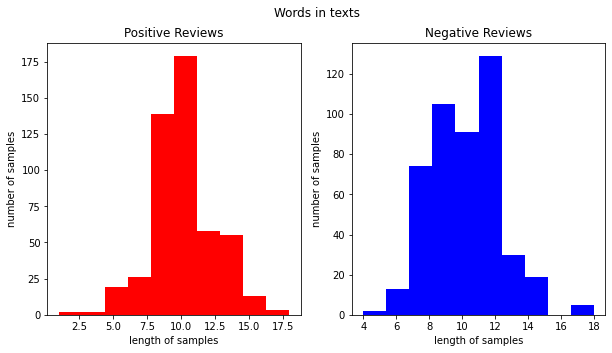

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

정수 인코딩

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 2343
등장 빈도가 1번 이하인 희귀 단어의 수: 1186
단어 집합에서 희귀 단어의 비율: 50.61886470337175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.110691310119472


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1159


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 18
리뷰의 평균 길이 : 10.158713692946058


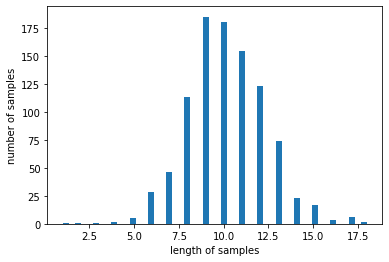

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 100.0


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

BiLSTM으로 감성 분류하기

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0.7, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
3/4 [=====================>........] - ETA: 0s - loss: 0.6936 - acc: 0.5091
Epoch 00001: val_acc improved from -inf to 0.50777, saving model to best_model.h5
4/4 [==============================] - 7s 561ms/step - loss: 0.6936 - acc: 0.5097 - val_loss: 0.6934 - val_acc: 0.5078
Epoch 2/15
3/4 [=====================>........] - ETA: 0s - loss: 0.6853 - acc: 0.5195
Epoch 00002: val_acc improved from 0.50777 to 0.62176, saving model to best_model.h5
4/4 [==============================] - 1s 216ms/step - loss: 0.6854 - acc: 0.5188 - val_loss: 0.6822 - val_acc: 0.6218
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 0.6577 - acc: 0.7004
Epoch 00003: val_acc did not improve from 0.62176
4/4 [==============================] - 1s 220ms/step - loss: 0.6577 - acc: 0.7004 - val_loss: 0.9953 - val_acc: 0.5078
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 0.6880 - acc: 0.7056
Epoch 00004: val_acc improved from 0.62176 to 0.63731, saving model to best_mo

In [ ]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

11/11 [==============================] - 1s 14ms/step - loss: 0.9230 - acc: 0.6211
테스트 정확도: 0.6211


제목에 따른 분노 예측하기

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정적 입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정적 입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('몰래 수천억 팔아치우다니…"또 당했다" 개미들 "패닉"')

82.92% 확률로 부정적 입니다.


In [ ]:
sentiment_predict('이재용이 해냈다…삼성, 인텔 제치고 반도체 매출 1위 등극')

79.76% 확률로 긍정적 입니다.


In [ ]:
sentiment_predict('1.2조 기술수출 잭팟 터뜨린 에이비엘바이오')

82.90% 확률로 긍정적 입니다.


In [ ]:
sentiment_predict('이재명 변호사비 대납 의혹 최초 제보자 숨진채 발견')

92.63% 확률로 긍정적 입니다.


In [ ]:
sentiment_predict('미 “북 탄도미사일 발사 규탄…도발 자제하고 대화 나오라”')

94.93% 확률로 부정적 입니다.


In [ ]:
sentiment_predict('세계은행 "올 성장률 4.1%, 내년 3.2%"')

91.25% 확률로 긍정적 입니다.


In [ ]:
sentiment_predict('"살아만 있어달라" 뜬눈 밤샘 가족들, 피 말리는 기다림')

86.86% 확률로 부정적 입니다.


In [ ]:
sentiment_predict('불법 유흥주점서 술자리 배우 최진혁 검찰 송치')

92.14% 확률로 긍정적 입니다.


In [ ]:
sentiment_predict('정경심, 어차피 다음달 석방인데…굳이 보석 청구, 왜?')

83.85% 확률로 부정적 입니다.


In [ ]:
test_data

,text,rank,label,tokenized
2554,시선집중 유시민 일베 놀이로 하이 리스크 하이 리턴 노려 유치한 망상 네이버 뉴스,0.1,0,"[시선집중, 유시민, 일, 베, 놀이, 로, 하이, 리스크, 하이, 리턴, 노려, ..."
2306,이재명 경부선 지하화 공약부산 등 도심철도 지하화 네이버 뉴스,0.3,1,"[이재명, 경부선, 지하, 화, 공약, 부산, 등, 도심, 철도, 지하, 화]"
1363,홍준표 과 회동 앞두고 굴러온 돌에 참패했지만 당 원망 안 해 네이버 뉴스,0.3,1,"[홍준표, 회동, 앞두, 굴러온, 돌, 참패, 했, 지만, 당, 원망, 안, 해]"
15,송영길 정부 이재명 탄압 윤영찬 왜 내부분열을 네이버 뉴스,0.1,0,"[송영길, 정부, 이재명, 탄압, 윤영찬, 왜, 내부, 분열]"
2866,조국 왜 사는 동네 아닌 이수 이마트까지 이준석 할인카드 있겠지 네이버 뉴스,0.3,1,"[조국, 왜, 사, 동네, 아닌, 이수, 이마트, 까지, 이준석, 할인, 카드, 있..."
...,...,...,...,...
3014,윤석열안철수 동시 타격 약진에 공세 전환 네이버 뉴스,0.4,1,"[윤석열, 안철수, 동시, 타격, 약진, 공세, 전환]"
2379,윤석열 임대료 임대인임차인국가가 분의 씩고통 분담 네이버 뉴스,0.3,1,"[윤석열, 임대료, 임대인, 임차인, 국가, 분의, 씩, 고통, 분담]"
179,막을 방법은 선제 타격뿐 발언에 전쟁광 비난 네이버 뉴스,0.1,0,"[막, 방법, 선제, 타격, 뿐, 발언, 전, 쟁광, 비난]"
681,선제타격이 답이다 윤석열 북한 핵미사일 위협 방지책 묻자 네이버 뉴스,0.3,1,"[선제, 타격, 답, 윤석열, 북한, 핵미사일, 위협, 방지책, 묻, 자]"


In [ ]:
happy_news = df['rank'] == 1
happy = df[happy_news]
happy

,text,rank,label
2669,김동연 세계 최초로 영상 발행경매수익은 기부 네이버 뉴스,1,1
2302,오늘내일 기자협회 초청 대선후보 토론회 방송 네이버 뉴스,1,1
